# Figure 1: Model performance

**Description:** Classification and cleavage deep learning model can accurately predict the location of polyA sites genome-wide and the cleavage probabilities surrounding them. Additionally, the development of a sequence strength models helps discriminate strong and weak sites.

&rarr; Run this notebook with the `tf-train` kernel


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
import utilities
from utilities import classification_cleavage, relative_strength, sequence, model_builder, genomic_context


In [5]:
## specify working directories

PROJECT = "/projects/b1080/eks/polyadenylation"
DATADIR = os.path.join(PROJECT, "manuscripts", "01_development", "data")
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_01")
os.makedirs(OUTDIR, exist_ok = True)


## IMPORT DATA

In [6]:
with open(os.path.join(DATADIR, "comprehensive_predictions", "polyaid_train_data.processed.pickle"), mode = "rb") as handle:
    polyaid_train_data = pickle.load(handle)
    
with open(os.path.join(DATADIR, "comprehensive_predictions", "polyaid_val_data.processed.pickle"), mode = "rb") as handle:
    polyaid_val_data = pickle.load(handle)
    
with open(os.path.join(DATADIR, "comprehensive_predictions", "polyaid_test_data.processed.pickle"), mode = "rb") as handle:
    polyaid_test_data = pickle.load(handle)
    
print("Train:", polyaid_train_data.shape)
print("Valid:", polyaid_val_data.shape)
print("Test: ", polyaid_test_data.shape)


Train: (1683371, 21)
Valid: (208165, 21)
Test:  (210225, 38)


In [7]:
cond1 = (polyaid_test_data['predclass'] == 'True Positive')
cond2 = (polyaid_test_data['our-models_classification'] > 0.9)
cond3 = (polyaid_test_data['our-models_cleavage_norm'].apply(lambda x : x[25] > 0.02))

polyaid_tpdata  = polyaid_test_data.loc[cond1].copy()
polyaid_posdata = polyaid_test_data.loc[cond1 & cond2 & cond3].copy()

print(polyaid_test_data.shape)
print(polyaid_tpdata.shape)
print(polyaid_posdata.shape)


(210225, 38)
(91297, 38)
(10771, 38)


In [8]:
with open(os.path.join(DATADIR, "comprehensive_predictions", "polyastrength_test_data.processed.pickle"), mode = "rb") as handle:
    polyastrength_test_data = pickle.load(handle)
    
with open(os.path.join(DATADIR, "comprehensive_predictions", "polyastrength_pairs.processed.pickle"), mode = "rb") as handle:
    polyastrength_pairs_data = pickle.load(handle)
    
with open(os.path.join(RESDIR, 'polyastrength_pairs.wide.pickle'), mode = 'rb') as handle:
    polyastrength_pairs_wide = pickle.load(handle)
    

## Model Performance

### Classification

#### Test split

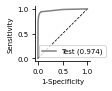

Corresponding metrics:
	Test AUROC = 0.9743700885169959


In [9]:
fig,axes = plt.subplots(1,1, figsize = (1,1))

test_auc = classification_cleavage.plot_roc(axes, 
                                            polyaid_test_data['binary_score'],
                                            polyaid_test_data['our-models_classification'],
                                            label = 'Test')

plt.savefig(os.path.join(OUTDIR, 'classification_performance.test_auroc.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding metrics:")
print(f"\tTest AUROC = {test_auc}")


#### All splits

In [10]:
labels = ['Training','Validation','Testing']
aurocs, auprcs = zip(*[classification_cleavage.calculate_auc(pdata['binary_score'], pdata['our-models_classification']) for pdata in [polyaid_train_data, polyaid_val_data, polyaid_test_data]])


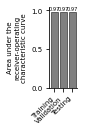

Corresponding metrics:
	Training	AUROC = 0.9739820169753732
	Validation	AUROC = 0.9741499302736149
	Testing	AUROC = 0.9743700885169959


In [11]:
fig,ax = plt.subplots(1, 1, figsize = (0.5,1.5))

ax.bar(x = np.arange(len(aurocs)), height = aurocs, color = 'gray', edgecolor = 'black', linewidth = 0.5)

for (i,a) in enumerate(aurocs):
    ax.text(x = i, y = a+0.01, s = str(round(a,2)), fontsize = 5, ha = 'center', va = 'bottom')

ax.set_xticks(np.arange(len(aurocs)))
ax.set_xticklabels(labels, rotation = 45, ha = 'right')

ax.set_ylabel("Area under the\nreceiver-operating\ncharacteristic curve")
ax.set_ylim((0,1.05))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'classification_performance.auroc_by_split.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding metrics:")
for p,p_auroc in zip(labels, aurocs): print(f"\t{p}\tAUROC = {p_auroc}")
    

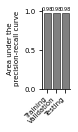

Corresponding metrics:
	Training	AUPRC = 0.9801795603370609
	Validation	AUPRC = 0.9803972785764126
	Testing	AUPRC = 0.9804936651406256


In [12]:
fig,ax = plt.subplots(1, 1, figsize = (0.5,1.5))

ax.bar(x = np.arange(len(auprcs)), height = auprcs, color = 'gray', edgecolor = 'black', linewidth = 0.5)

for (i,a) in enumerate(auprcs):
    ax.text(x = i, y = a+0.01, s = str(round(a,2)), fontsize = 5, ha = 'center', va = 'bottom')

ax.set_xticks(np.arange(len(aurocs)))
ax.set_xticklabels(labels, rotation = 45, ha = 'right')

ax.set_ylabel("Area under the\nprecision-recall curve")
ax.set_ylim((0,1.05))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'classification_performance.auprc_by_split.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding metrics:")
for p,p_auprc in zip(labels, auprcs): print(f"\t{p}\tAUPRC = {p_auprc}")
    

#### As a function of overall relative usage

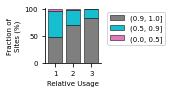

Corresponding metrics:
Number of sites in each usage bin-
ru_bins3
(0.0, 0.2]    3886
(0.2, 0.8]     887
(0.8, 1.0]     504
Name: count, dtype: int64


In [13]:
fig,ax = plt.subplots(1,1, figsize = (1, 1))

plot_data = polyastrength_test_data.copy()

plot_data['classification_bin'] = pd.cut(plot_data['our-models_classification'], bins = [0,0.5,0.9,1])
plot_data['ru_bins3'] = pd.cut(plot_data['relative_usage'], bins = [0,0.2,0.8,1.0])
plot_data = plot_data.groupby(['classification_bin','ru_bins3']).size().reset_index().rename(columns = {0:'count'})
plot_data['ru_bins3_frac'] = plot_data['count'] / plot_data.groupby('classification_bin')['count'].transform('sum') * 100
plot_data['class_bins_frac'] = plot_data['count'] / plot_data.groupby('ru_bins3')['count'].transform('sum') * 100

class1_data = plot_data.loc[plot_data['classification_bin'] == plot_data['classification_bin'].unique()[0], 'class_bins_frac'].to_numpy()
class2_data = plot_data.loc[plot_data['classification_bin'] == plot_data['classification_bin'].unique()[1], 'class_bins_frac'].to_numpy()
class3_data = plot_data.loc[plot_data['classification_bin'] == plot_data['classification_bin'].unique()[2], 'class_bins_frac'].to_numpy()

ax.bar([1,2,3], class3_data, edgecolor = 'black', linewidth = 0.5, color = 'C7', label = plot_data['classification_bin'].unique()[2])
ax.bar([1,2,3], class2_data, bottom = class3_data, edgecolor = 'black', linewidth = 0.5, color = 'C9', label = plot_data['classification_bin'].unique()[1])
ax.bar([1,2,3], class1_data, bottom = class3_data+class2_data, edgecolor = 'black', linewidth = 0.5, color = 'C6', label = plot_data['classification_bin'].unique()[0])

ax.set_ylim(0,101)
ax.legend(bbox_to_anchor = (1.05,1))

ax.set_xlabel("Relative Usage")
ax.set_ylabel("Fraction of\nSites (%)")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'classification_performance.stackedbar_by_ru.flipped.svg'), format = 'svg', dpi = 600)
plt.show()


print("Corresponding metrics:")
print("Number of sites in each usage bin-")
print(plot_data.groupby('ru_bins3')['count'].sum())


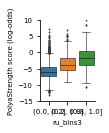

Corresponding metrics:
Number of sites in each usage bin-
             count      mean       std        min       25%       50%  \
ru_bins3                                                                
(0.0, 0.2]  3886.0 -5.664141  2.381193 -13.190360 -7.233835 -5.945035   
(0.2, 0.8]   887.0 -3.458875  2.629775  -8.952475 -5.459996 -3.815488   
(0.8, 1.0]   504.0 -1.557789  3.190232 -10.708541 -3.884048 -1.779701   

                 75%       max  
ru_bins3                        
(0.0, 0.2] -4.434760  7.200404  
(0.2, 0.8] -1.783391  6.722204  
(0.8, 1.0]  0.432313  9.978630  


In [14]:
fig,ax = plt.subplots(1,1, figsize = (1, 1.5))

plot_data = polyastrength_test_data.copy()
plot_data['ru_bins3'] = pd.cut(plot_data['relative_usage'], bins = [0,0.2,0.8,1.0])

sns.boxplot(data = plot_data, x = 'ru_bins3', y = 'our-models_strength',
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black', 'markersize': 1},
            ax = ax, showfliers = True)

ax.set_ylabel("PolyaStrength score (log-odds)")
ax.set_ylim(-15,10)
ax.yaxis.set_major_locator(MultipleLocator(5))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'strength_performance.correlation_boxplots.svg'), format = 'svg', dpi = 600)
plt.show()

print("Corresponding metrics:")
print("Number of sites in each usage bin-")
print(plot_data.groupby('ru_bins3')['our-models_strength'].describe())


#### Partitioning highly and lowly used sites

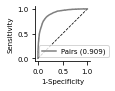

Corresponding metrics:
Number of pairs- 8167


In [15]:
fig,ax = plt.subplots(1, 1, figsize = (1,1))

pairs_auc = classification_cleavage.plot_roc(ax, 
                                             polyastrength_pairs_wide['random_class'],
                                             polyastrength_pairs_wide['random_difference'],
                                             label = 'Pairs')

plt.savefig(os.path.join(OUTDIR, 'strength_performance.pairs_roc.svg'), format = 'svg', dpi = 600)
plt.show()


print("Corresponding metrics:")
print("Number of pairs-", len(polyastrength_pairs_wide))


### Cleavage Probabilities

In [16]:
xs = np.arange(-25,25,1)
polyaid_tpdata['scorevec_mcp'] = polyaid_tpdata['scorevec'].apply(lambda y : np.dot(xs, y/np.sum(y)))


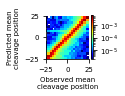

Corresponding metrics:
	Spearman correlation = 0.9627477983006325


In [17]:
fig,ax = plt.subplots(1, 1, figsize = (1.75, 2))

pcorr = classification_cleavage.plot_cleavage_evaluation(fig, ax, polyaid_tpdata['scorevec_mcp'], polyaid_tpdata['our-models_mcp-raw'], corr = False)

ax.set_xlabel("Observed mean\ncleavage position")
ax.set_ylabel("Predicted mean\ncleavage position")

ax.set_xlim(-25,25)
ax.xaxis.set_major_locator(MultipleLocator(25))

ax.set_ylim(-25,25)
ax.yaxis.set_major_locator(MultipleLocator(25))

plt.tight_layout(rect = [0, 0.03, 1, 0.97])
plt.savefig(os.path.join(OUTDIR, 'cleavage_probabilities.correlation_mcp.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()

print(f"Corresponding metrics:\n\tSpearman correlation = {pcorr}")


## Cleavage Profile Consolidation

In [18]:
genome = sequence.loadgenome(os.path.join(DATADIR, "hg38.genome.fa"))

with open(os.path.join(DATADIR, "reads3_scoring_dictionary.pickle"), mode = 'rb') as handle:
    reads_dict = pickle.load(handle)


### Simple Example: HBA2

In [19]:
example = {
    'gene' : 'HBA2',
    'transcript' : 'ENST00000251595',
    'chrom' : 'chr16',
    'strand' : '+',
    'start' : 172775,
    'end' : 173910,
    'gene_start' : 172875,
    'gene_end' : 173710,
    'coding_start' : 172912,
    'coding_end' : 173600,
    'exon_starts' : [172875,173124,173471],
    'exon_ends' : [173007,173329,173710],
}

with open(os.path.join(RESDIR, 'prediction_inputs.simple_hba2.pickle'), mode = 'rb') as handle:
    inputs = pickle.load(handle)


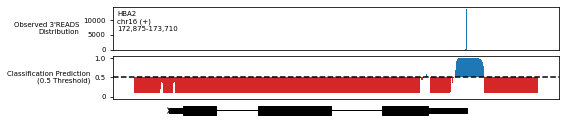

In [20]:
fig,axes = plt.subplots(3, 1, figsize = (8,2), sharex = True, gridspec_kw = {'height_ratios' : [1,1,0.25]})

classification_cleavage.whole_gene_classification(axes, example, inputs, reads_dict, nbins = 300)

axes[0].set_ylabel("\n".join(wrap("Observed 3'READS Distribution", 25)), rotation = 0, ha = 'right', va = 'center')
axes[1].set_ylabel("\n".join(wrap("Classification Prediction (0.5 Threshold)", 25)), rotation = 0, ha = 'right', va = 'center')

plt.savefig(os.path.join(OUTDIR, 'whole_gene_classification.simple_hba2.pdf'), format = 'pdf', dpi = 600, transparent = True)
plt.show()


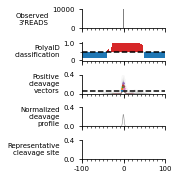

In [21]:
fig,axes = plt.subplots(5, 1, figsize = (2.5,2.5), sharex = True)

classification_cleavage.cleavage_profile_explanation(axes, example, inputs, reads_dict, genome, 
                                                     visible_region = (173709-100, 173709+100), visible_labels = 'relative',
                                                     cutoff_class = 0.5, cutoff_clv = 0.05, normalize = True,
                                                     ylims_3reads = (0,10000), ylims_clv = (0,0.4))

axes[0].set_ylabel("Observed\n3'READS",             rotation = 0, ha = 'right', va = 'center')
axes[1].set_ylabel("PolyaID\nclassification",       rotation = 0, ha = 'right', va = 'center')
axes[2].set_ylabel("Positive\ncleavage\nvectors",   rotation = 0, ha = 'right', va = 'center')
axes[3].set_ylabel("Normalized\ncleavage\nprofile", rotation = 0, ha = 'right', va = 'center')
axes[4].set_ylabel("Representative\ncleavage site", rotation = 0, ha = 'right', va = 'center')

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'cleavage_profile_explanation.simple_hba2.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


### Complex Example: GPATCH11

In [22]:
example = {
    'gene' : 'GPATCH11',
    'transcript' : 'NM_001278505.2',
    'chrom' : 'chr2',
    'strand' : '+',
    'start' : 37084517-100,
    'end' : 37099244+100,
    'gene_start' : 37084517,
    'gene_end' : 37099244,
    'coding_start' : 37088433,
    'coding_end' : 37096263,
    'exon_starts' : [37084517,37088368,37091915,37092164,37094081,37095436,37096207],
    'exon_ends' : [37084570,37088440,37092036,37092255,37094195,37095518,37099244],
}

with open(os.path.join(RESDIR, 'prediction_inputs.complex_gpatch11.pickle'), mode = 'rb') as handle:
    inputs = pickle.load(handle)


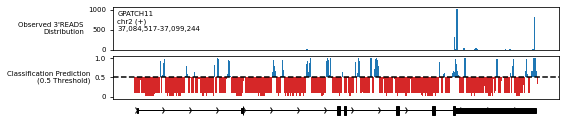

In [23]:
fig,axes = plt.subplots(3, 1, figsize = (8,2), sharex = True, gridspec_kw = {'height_ratios' : [1,1,0.25]})

classification_cleavage.whole_gene_classification(axes, example, inputs, reads_dict, nbins = 300, arrow_int = 1000)

axes[0].set_ylabel("\n".join(wrap("Observed 3'READS Distribution", 25)), rotation = 0, ha = 'right', va = 'center')
axes[1].set_ylabel("\n".join(wrap("Classification Prediction (0.5 Threshold)", 25)), rotation = 0, ha = 'right', va = 'center')

plt.savefig(os.path.join(OUTDIR, 'whole_gene_classification.complex_gpatch11.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


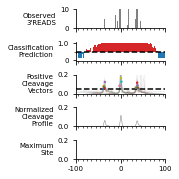

In [24]:
fig,axes = plt.subplots(5, 1, figsize = (2.5,2.5), sharex = True)

classification_cleavage.cleavage_profile_explanation(axes, example, inputs, reads_dict, genome, 
                                                     visible_region = (37099205-100, 37099205+100), visible_labels = 'relative',
                                                     cutoff_class = 0.5, cutoff_clv = 0.05, normalize = True, ylims_3reads = (0,10), ylims_clv = (0,0.2))

axes[0].set_ylabel("Observed\n3'READS", rotation = 0, ha = 'right', va = 'center')
axes[1].set_ylabel("Classification\nPrediction", rotation = 0, ha = 'right', va = 'center')
axes[2].set_ylabel("Positive\nCleavage\nVectors", rotation = 0, ha = 'right', va = 'center')
axes[3].set_ylabel("Normalized\nCleavage\nProfile", rotation = 0, ha = 'right', va = 'center')
axes[4].set_ylabel("Maximum\nSite", rotation = 0, ha = 'right', va = 'center')

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'cleavage_profile_explanation.complex_gpatch11.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


## 3'READS Sites

### By signal

#### Number of sites

In [25]:
reads3_sites_clust = pd.read_csv(os.path.join(DATADIR, 'reads3_polya_sites.annotated.clust_assoc.txt'))
print(reads3_sites_clust.shape, reads3_sites_clust['gene'].nunique())


(109814, 19) 22457


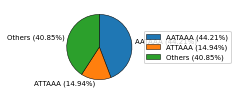

Corresponding data:
        count      prop            label
signal                                  
AATAAA  48551  0.442120  AATAAA (44.21%)
ATTAAA  16405  0.149389  ATTAAA (14.94%)
Others  44858  0.408491  Others (40.85%)


In [26]:
fig,ax = plt.subplots(1,1, figsize = (1.5,1.5))

signal_ordering = ['AATAAA','ATTAAA','Others']

plot_data = (reads3_sites_clust
             ['signal2']
             .value_counts()
             .reset_index()
             .rename(columns = {'signal2': 'count', 'index' : 'signal'})
            )

plot_data['prop'] = plot_data['count'] / plot_data['count'].sum()
plot_data['label'] = plot_data['signal'] + " (" + (plot_data['prop']*100).round(2).astype(str) + "%)"
plot_data = plot_data.set_index('signal')
plot_data = plot_data.loc[signal_ordering]

wedges, texts = plt.pie(plot_data['prop'], 
                        labels = plot_data['label'],
                        startangle = 90, counterclock = False,
                        wedgeprops = {'linewidth' : 0.5, 'edgecolor' : 'black'}
                       )

ax.legend(wedges, plot_data['label'],
          title="",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig(os.path.join(OUTDIR, 'sites_by_upstream_signal.clust.pie.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding data:")
print(plot_data)


### Nucleotide density

#### Overall

In [27]:
with open(os.path.join(RESDIR, 'reads3_polya_sites.nucleotide_density.clust.pickle'), mode = 'rb') as handle:
    nt_dict = pickle.load(handle)
    

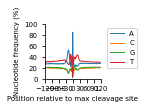

In [28]:
fig,ax = plt.subplots(1,1, figsize = (1,1))

xs = np.arange(-120,120,1)
plot_data = nt_dict['all']

ax.plot(xs, plot_data[:,0]*100, linewidth = 1, label = 'A')
ax.plot(xs, plot_data[:,1]*100, linewidth = 1, label = 'C')
ax.plot(xs, plot_data[:,2]*100, linewidth = 1, label = 'G')
ax.plot(xs, plot_data[:,3]*100, linewidth = 1, label = 'T')

ax.legend(bbox_to_anchor = (1.05,1.0))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("Position relative to max cleavage site")
ax.set_xlim(-120,120)
ax.xaxis.set_major_locator(MultipleLocator(30))

ax.set_ylabel("Nucleotide frequency (%)")
ax.set_ylim(0,100)
ax.yaxis.set_major_locator(MultipleLocator(20))

plt.savefig(os.path.join(OUTDIR, '01.supp.nucleotide_density.overall.clust.svg'), format = 'svg', dpi = 600)
plt.show()


AATAAA	0.76	89.83


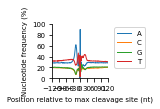

ATTAAA	0.78	89.84


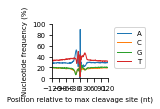

Others	4.30	79.53


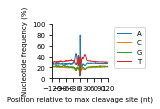

In [29]:
for signal in ['AATAAA','ATTAAA','Others']:

    fig,ax = plt.subplots(1,1, figsize = (1,1))

    xs = np.arange(-120,120,1)
    plot_data = nt_dict[signal]

    ax.plot(xs, plot_data[:,0]*100, linewidth = 1, label = 'A')
    ax.plot(xs, plot_data[:,1]*100, linewidth = 1, label = 'C')
    ax.plot(xs, plot_data[:,2]*100, linewidth = 1, label = 'G')
    ax.plot(xs, plot_data[:,3]*100, linewidth = 1, label = 'T')
    
    print(f'{signal}\t{np.min(plot_data*100):.02f}\t{np.max(plot_data*100):.02f}')

    ax.legend(bbox_to_anchor = (1.05,1.0))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlabel("Position relative to max cleavage site (nt)")
    ax.set_xlim(-120,120)
    ax.xaxis.set_major_locator(MultipleLocator(30))

    ax.set_ylabel("Nucleotide frequency (%)")
    ax.set_ylim(0,100)
    ax.yaxis.set_major_locator(MultipleLocator(20))

    plt.savefig(os.path.join(OUTDIR, f'01.supp.nucleotide_density.clust.{signal.lower()}.svg'), format = 'svg', dpi = 600)
    plt.show()
